# **Neural Network Exercise 3**
## Part 2

---

Teacher : Dr.Kheradpisheh 

Student : Amin Dehghan Monfared	     
SID : 99422085 



Spring 2021 

In [ ]:
import os
import sys
import random
import time
import datetime
import shutil
import glob

import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import datetime



import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
from torch.autograd import Variable

import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from torch.utils.tensorboard import SummaryWriter

import functools
import operator


# Get Data

https://www.kaggle.com/moltean/fruits

helpful link:

https://becominghuman.ai/variational-autoencoders-for-new-fruits-with-keras-and-pytorch-6d0cfc4eeabd

In [ ]:
# Download Data From Kaggle api

!pip install -q kaggle

from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d moltean/fruits


# unzip files 
import zipfile 

zip_ref = zipfile.ZipFile('fruits.zip','r')
zip_ref.extractall('./data/')
zip_ref.close()

!rm ./fruits.zip

Saving kaggle.json to kaggle.json
100% 758M/760M [00:16<00:00, 42.9MB/s]
100% 760M/760M [00:16<00:00, 47.1MB/s]


# Load Data

In [ ]:
# Add the transformation of image
data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((100, 100)),
    transforms.Normalize((0.5,)*3, (0.5,)*3)
])


# Path for training and validation dataset
train_path = "/content/data/fruits-360/Training"
test_path = "/content/data/fruits-360/Test"

In [ ]:
# Create train dataset
train_dataset = ImageFolder(train_path,
                               transform=data_transforms)

# Create train dataloader
train_loader = DataLoader(train_dataset,
                                 batch_size=64,
                                 shuffle=True)

# Create test dataset
val_dataset = ImageFolder(test_path,
                               transform=data_transforms)

# Create test dataloader
val_loader = DataLoader(val_dataset,
                                 batch_size=64,
                                 shuffle=False)

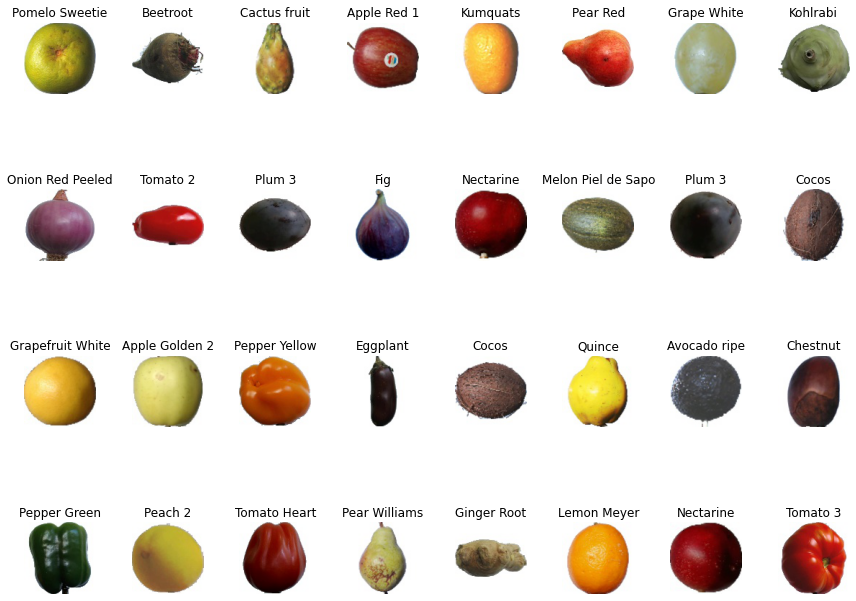

In [ ]:
image_size = 32

# Get the image from dataloader
show_images, show_labels = next(iter(train_loader))
show_images = show_images[:image_size]
show_labels = show_labels[:image_size]

ncols = 8
nrows = int(image_size / ncols) + 1

# Set up the figure size
plt.figure(figsize=(12, 12))


def inverse_normalized(image):
    # Clamp the value to (0.0, 1.0) for floats
    image = torch.clamp(input=image * 0.5 + 0.5,
                        min=0.0,
                        max=1.0)
    return image


for idx in range(len(show_images)):
    # Set up the subplot
    plt.subplot(nrows, ncols, idx + 1)
    
    # Close the axis and plot the image
    plt.axis("off")
    # Note that the label is change into integer, we should change it back to category
    plt.title(train_dataset.classes[show_labels[idx].item()])
    # Note that the image channel of tensor is: (channel, width, height)
    # We need to change it to (width, height, channel) which we use permute to realize it
    plt.imshow(inverse_normalized(show_images[idx].permute(1, 2, 0)))

# Avoid overlapping of different titles
plt.tight_layout()

# Create NN

In [ ]:
class AverageMeter(object):
  '''A handy class from the PyTorch ImageNet tutorial''' 
  def __init__(self):
    self.reset()
  def reset(self):
    self.val, self.avg, self.sum, self.count = 0, 0, 0, 0
  def update(self, val, n=1):
    self.val = val
    self.sum += val * n
    self.count += n
    self.avg = self.sum / self.count

In [ ]:
class VAE (nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        
        # Encoder
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 16, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(16)
        
        # Latent vectors mu and sigma
        self.fc1 = nn.Linear(25 * 25 * 16, 2048)
        self.fc_bn1 = nn.BatchNorm1d(2048)
        self.fc21 = nn.Linear(2048, 2048)
        self.fc22 = nn.Linear(2048, 2048)
        
        # Sampling vector
        self.fc3 = nn.Linear(2048, 2048)
        self.fc_bn3 = nn.BatchNorm1d(2048)
        self.fc4 = nn.Linear(2048, 25 * 25 * 16)
        self.fc_bn4 = nn.BatchNorm1d(25 * 25 * 16)
        
        # Decoder
        self.conv5 = nn.ConvTranspose2d(16, 64, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False)
        self.bn5 = nn.BatchNorm2d(64)
        self.conv6 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn6 = nn.BatchNorm2d(32)
        self.conv7 = nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False)
        self.bn7 = nn.BatchNorm2d(16)
        self.conv8 = nn.ConvTranspose2d(16, 3, kernel_size=3, stride=1, padding=1, bias=False)
        self.relu = nn.ReLU()
    
    
    def encode(self, x):
    
        # Encode
        conv1 = self.relu(self.bn1(self.conv1(x)))
        conv2 = self.relu(self.bn2(self.conv2(conv1)))
        conv3 = self.relu(self.bn3(self.conv3(conv2)))
        conv4 = self.relu(self.bn4(self.conv4(conv3))).view(-1, 25*25* 16)

        # Calculate latent vectors 
        fc1 = self.relu(self.fc_bn1(self.fc1(conv4)))
        mu = self.fc21(fc1)
        logvar = self.fc22(fc1)

        return mu, logvar

    def reparameterize(self, mu, logvar):
        
        #Sample From latent vectors 
        std = logvar.mul(0.5).exp_()
        eps = Variable(std.data.new(std.size()).normal_())
        z = eps.mul(std).add_(mu)

        return z

    def decode(self,z):

        # Decode 
        fc3 = self.relu(self.fc_bn3(self.fc3(z)))
        fc4 = self.relu(self.fc_bn4(self.fc4(fc3))).view(-1, 16, 25, 25)
        conv5 = self.relu(self.bn5(self.conv5(fc4)))
        conv6 = self.relu(self.bn6(self.conv6(conv5)))
        conv7 = self.relu(self.bn7(self.conv7(conv6)))
        out = self.conv8(conv7).view(-1, 3, 100, 100)

        return out

    def forward(self, x):
        
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        out = self.decode(z)

        return out, mu, logvar 


In [ ]:
# Define Loss Function

class Loss(nn.Module):
    def __init__(self):
        super(Loss, self).__init__()
        self.mse_loss = nn.MSELoss(reduction="sum")    
        
    def forward(self, recon_x, x, mu, logvar):
        MSE = self.mse_loss(recon_x, x)
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2)-logvar.exp())        
        
        return MSE + KLD


In [ ]:
model = VAE()
criterion = Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.0)

In [ ]:
log_root = './train5/'

In [ ]:
log_dir = log_root + datetime.datetime.now().strftime("%d-%H")
tb = SummaryWriter(log_dir)

images, labels = next(iter(training_dataloader))
grid = torchvision.utils.make_grid(images)
#tb.add_image("images", grid)
tb.add_graph(model, images)
tb.close()

/usr/local/lib/python3.7/dist-packages/torch/jit/_trace.py:966: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
With rtol=1e-05 and atol=1e-05, found 1913218 element(s) (out of 1920000) whose difference(s) exceeded the margin of error (including 0 nan comparisons). The greatest difference was 0.01442656759172678 (-0.010805201716721058 vs. 0.003621365875005722), which occurred at index (29, 0, 54, 56).
  _module_class,


In [ ]:
use_gpu = torch.cuda.is_available()
use_gpu

True

In [ ]:
# Move model and loss function to GPU
if use_gpu: 
  criterion = criterion.cuda()
  model = model.cuda()

In [ ]:
def train(train_loader, model, criterion, optimizer, epoch):
  print('Starting training epoch {}'.format(epoch))
  model.train()

  # Prepare value counters and timers
  batch_time, data_time, losses = AverageMeter(), AverageMeter(), AverageMeter()

  end = time.time()
  for i, (image, _) in enumerate(train_loader):
    
    # Use GPU if available
    if use_gpu: image = image.cuda()

    # Record time to load data (above)
    data_time.update(time.time() - end)

    # Run forward pass
    output, mu, std = model(image) 
    loss = criterion(output, image, mu, std) 
    losses.update(loss.item(), image.size(0))
    

    # Compute gradient and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Record time to do forward and backward passes
    batch_time.update(time.time() - end)
    end = time.time()

   
    # Print model accuracy -- in the code below, val refers to value, not validation
    if i+1 % 10 == 0 or i+1 == len(train_loader):
      print('Epoch: [{0}][{1}/{2}]\t'
            'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
            'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
            'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(
              epoch, i+1, len(train_loader), batch_time=batch_time,
             data_time=data_time, loss=losses)) 
      
  return losses.avg



In [ ]:
def sample_new_fruits():
    sample_nums = 16
    sample = torch.randn(sample_nums, 2048).cuda()
    sample_img = model.decode(sample).cpu()

    ncols = 8
    nrows = int(sample_nums / ncols) + 1

    fig = plt.figure()

    for idx in range(len(sample)):
        # Set up the subplot
        ax =fig.add_subplot(nrows, ncols, idx + 1)
        
        # Close the axis and plot the image
        ax.axis("off")
    
        # Note that the image channel of tensor is: (channel, width, height)
        # We need to change it to (width, height, channel) which we use permute to realize it
        ax.imshow(inverse_normalized(sample_img[idx].squeeze().permute(1, 2, 0).cpu()).detach().numpy())

    fig.subplots_adjust(hspace=.25, wspace=.25)

In [ ]:
## Create tb 
log_dir = log_root + datetime.datetime.now().strftime("%d-%H:%M")
comment = f''
tb = SummaryWriter(log_dir+ comment) 
passed_epochs = 0  

In [ ]:
epochs= 20

In [ ]:

#Train model
for epoch in range(epochs):

  # Train for one epoch, then validate
  train(training_dataloader, model, criterion, optimizer, passed_epochs+1)
  

  if passed_epochs % 10 ==0:

    sample_nums = 16
    sample = torch.randn(sample_nums, 2048).cuda()
    sample_img = model.decode(sample).cpu()

    ncols = 8
    nrows = int(sample_nums / ncols) + 1

    fig = plt.figure()

    for idx in range(len(sample)):
        # Set up the subplot
        ax =fig.add_subplot(nrows, ncols, idx + 1)
        
        # Close the axis and plot the image
        ax.axis("off")
    
        # Note that the image channel of tensor is: (channel, width, height)
        # We need to change it to (width, height, channel) which we use permute to realize it
        ax.imshow(inverse_normalized(sample_img[idx].squeeze().permute(1, 2, 0).cpu()).detach().numpy())

    fig.subplots_adjust(hspace=.25, wspace=.25)

    tb.add_figure('New Generated Images epoch{}'.format(passed_epochs+1),
                            fig,global_step=passed_epochs+1)
    name = 'New Generated Images epoch{}'.format(passed_epochs+1)
    plt.savefig(name+'.png', dpi=300, bbox_inches='tight')
  
  passed_epochs += 1

NameError: ignored

In [ ]:
tb.close()

In [ ]:
tb.get_logdir()

'./train3/21-17:39'

In [ ]:
def validate(test_loader, model, criterion,save_image, epoch):

    print('Starting Validating epoch {}'.format(epoch))
    model.eval()

    
    with torch.no_grad():
        # Prepare value counters and timers
        batch_time, data_time, losses = AverageMeter(), AverageMeter(), AverageMeter()
        end = time.time()
        already_saved_images = False
        for i, (image, label) in enumerate(test_loader):

            # Use GPU if available
            if use_gpu: image = image.cuda()

            # Record time to load data (above)
            data_time.update(time.time() - end)

            # Run forward pass
            output, mu, std = model(image) 
            loss = criterion(output, image, mu, std) 
            losses.update(loss.item(), image.size(0))

            # Save images to file
            if save_images and not already_saved_images:
              already_saved_images = True
              for j in range(min(len(image), 5)): # save at most 5 images
                save_path = 'outputs/reconstructs/'
                img_name = 'recon_img_{}_epoch_{}.png'.format(j,epoch)
                
                plt.clf() # clear matplotlib 
                fig2 = plt.figure()
                ax1 = fig2.add_subplot(1,2,1)
                ax1.axis('off')
                ax1.set_title(train_dataset.classes[label[j].item()])
                ax1.imshow(inverse_normalized(image[j].permute(1, 2, 0).cpu()))

                out, mu, logVAR = model(image[j].unsqueeze(0))
                outimg = np.transpose(out[0].cpu().numpy(), [1,2,0])

                ax2 =fig2.add_subplot(1,2,2)
                
                ax2.axis('off')
                ax2.imshow(inverse_normalized(out.squeeze().permute(1, 2, 0).cpu()))
                fig2.savefig(save_path+img_name)

                plt.close(fig2)

            # Record time to do forward and backward passes
            batch_time.update(time.time() - end)
            end = time.time()  
                
            # Print model accuracy -- in the code below, val refers to value, not validation
            if i+1 % 10 == 0 or i+1 == len(test_loader):
                print('Epoch: [{0}][{1}/{2}]\t'
                    'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                    'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                    'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(
                        epoch, i+1, len(train_loader), batch_time=batch_time,
                        data_time=data_time, loss=losses)) 
                
    return losses.avg


In [ ]:
# trying to save reconstruct problem
def validate(test_loader, model, criterion,save_image, epoch):

    print('Starting Validating epoch {}'.format(epoch))
    model.eval()

    
    with torch.no_grad():
        # Prepare value counters and timers
        batch_time, data_time, losses = AverageMeter(), AverageMeter(), AverageMeter()
        end = time.time()
        already_saved_images = False
        for i, (image, label) in enumerate(test_loader):

            # Use GPU if available
            if use_gpu: image = image.cuda()

            # Record time to load data (above)
            data_time.update(time.time() - end)

            # Run forward pass
            output, mu, std = model(image) 
            loss = criterion(output, image, mu, std) 
            losses.update(loss.item(), image.size(0))

            # Save images to file
            if save_images and i in np.linspace(0, len(test_loader), 5).astype(int) :
              
              # save a pic on ech batch 
                save_path = 'outputs/reconstructs/'
                img_name = 'recon_img_{}_epoch_{}.png'.format(i,epoch)
                
                plt.clf() # clear matplotlib 
                fig2 = plt.figure()
                ax1 = fig2.add_subplot(1,2,1)
                ax1.axis('off')
                ax1.set_title(train_dataset.classes[label[0].item()])
                ax1.imshow(inverse_normalized(image[0].permute(1, 2, 0).cpu()))

                out, mu, logVAR = model(image[0].unsqueeze(0))
                outimg = np.transpose(out[0].cpu().numpy(), [1,2,0])

                ax2 =fig2.add_subplot(1,2,2)
                
                ax2.axis('off')
                ax2.imshow(inverse_normalized(out.squeeze().permute(1, 2, 0).cpu()))
                fig2.savefig(save_path+img_name)

                plt.close(fig2)

            # Record time to do forward and backward passes
            batch_time.update(time.time() - end)
            end = time.time()  
                
            # Print model accuracy -- in the code below, val refers to value, not validation
            if i+1 % 10 == 0 or i+1 == len(test_loader):
                print('Epoch: [{0}][{1}/{2}]\t'
                    'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                    'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                    'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(
                        epoch, i+1, len(train_loader), batch_time=batch_time,
                        data_time=data_time, loss=losses)) 
                
    return losses.avg


RuntimeError: ignored

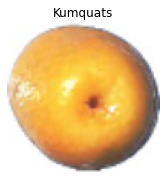

In [ ]:


model.eval()

idx = 4
show_images, show_labels = next(iter(train_loader))
image, label = show_images[idx], show_labels[idx]

img = image.cuda()

plt.subplot(121)
plt.axis('off')
plt.title(train_dataset.classes[show_labels[idx].item()])
plt.imshow(inverse_normalized(img.permute(1, 2, 0).cpu()))

out, mu, logVAR = model(img.unsqueeze(0))

outimg = np.transpose(out[0].cpu().numpy(), [1,2,0])
plt.subplot(122)
plt.axis('off')
plt.imshow(inverse_normalized(out.squeeze().permute(1, 2, 0).cpu()))
    

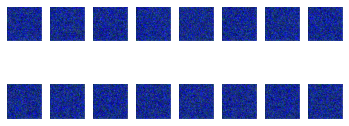

In [ ]:
sample_nums = 16
sample = torch.randn(sample_nums, 2048)
sample_img = model.decode(sample).cpu()

ncols = 8
nrows = int(sample_nums / ncols) + 1

fig = plt.figure()

for idx in range(len(sample)):
    # Set up the subplot
    ax =fig.add_subplot(nrows, ncols, idx + 1)
    
    # Close the axis and plot the image
    ax.axis("off")
  
    # Note that the image channel of tensor is: (channel, width, height)
    # We need to change it to (width, height, channel) which we use permute to realize it
    ax.imshow(inverse_normalized(sample_img[idx].squeeze().permute(1, 2, 0).cpu()).detach().numpy())

fig.subplots_adjust(hspace=.25, wspace=.25)

log_dir = log_root + datetime.datetime.now().strftime("%d-%H")
tb = SummaryWriter(log_dir)
tb.add_figure('New',fig, global_step= passed_epochs+1)
fig

## Ablation Studies


In [ ]:
from itertools import product

# # log samling in [1e-4 , 1e-1] for learning rate
# r = -4* np.random.rand(3)
# lr = 10 ** r
# print(lr)


parameters = dict(
    lr = [ 1e-3, 1e-4, 1e-5 ],
    weight_decay = [0.1]
)




param_values = [v for v in parameters.values()]

print(param_values)

for lr, weight_decay  in product(*param_values):
    print(lr, weight_decay)

[[0.001, 0.0001, 1e-05], [0.1]]
0.001 0.1
0.0001 0.1
1e-05 0.1


In [ ]:
log_root = '/content/drive/MyDrive/NN_ass3_2/'

In [ ]:
use_gpu = torch.cuda.is_available()
use_gpu

True

In [ ]:
epochs = 50

for run_id, (lr, weight_decay) in enumerate(product(*param_values)):
  print("run id:", run_id + 1)

  #Create Folder For Saving Results 
  os.chdir('/content') 
  log_dir = datetime.datetime.now().strftime("%m-%d %H:%M")
  os.makedirs(log_dir, exist_ok=True)
  os.chdir(log_dir)

  # Create Run Modules 
  model = VAE()
  optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
  criterion = Loss()

  # Write Run Description to txt file 
  desc = '{},\n Optimizer {},\n criterion: {},\n Epochs: {}'.format(
                    model.__class__.__name__, optimizer , criterion,epochs)
  desc_log= open("desc.txt","w+")
  desc_log.write(desc)
 
  print(desc,'\n')

  # Move model and loss function to GPU
  if use_gpu: 
    criterion = criterion.cuda()
    model = model.cuda()

  # Make folders and set parameters
  os.makedirs('outputs/samples', exist_ok=True)
  os.makedirs('outputs/reconstructs', exist_ok=True)
  os.makedirs('checkpoints', exist_ok=True)
  
  best_losses = 1e10

  # Train model
  train_losses = []
  val_losses = []
  for epoch in range(1,epochs+1):

    # Train for one epoch, then validate
    train_loss = train(train_loader, model, criterion, optimizer, epoch)
    train_losses.append(train_loss)

    # Generater New Pictures
    if epoch % 10 ==0 or epoch == 1:

      sample_nums = 16
      sample = torch.randn(sample_nums, 2048).cuda()
      sample_img = model.decode(sample).cpu()

      ncols = 8
      nrows = int(sample_nums / ncols) + 1
      
      plt.clf() # clear matplotlib 
      fig = plt.figure()

      for idx in range(len(sample)):
          # Set up the subplot
          ax =fig.add_subplot(nrows, ncols, idx + 1)
          
          # Close the axis and plot the image
          ax.axis("off")
          ax.legend_ = None
          # Note that the image channel of tensor is: (channel, width, height)
          # We need to change it to (width, height, channel) which we use permute to realize it
          ax.imshow(inverse_normalized(sample_img[idx].squeeze().permute(1, 2, 0).cpu()).detach().numpy())

      fig.subplots_adjust(hspace=.25, wspace=.25)

      save_path = 'outputs/samples/'
      name = 'new_generated_images_epoch{}.png'.format(epoch)
      fig.savefig(save_path+name, dpi=300, bbox_inches='tight')
      plt.close(fig)

    with torch.no_grad():
      save_images = False 
      if epoch % 10 == 0 or epoch == 1 or epoch == epochs:
        save_images = True 
        
      val_loss = validate(val_loader, model, criterion, save_images, epoch)
      val_losses.append(val_loss)

    # Save checkpoint and replace old best model if current model is better
    if val_loss < best_losses:
      best_losses = val_loss
      # Remove Previouse Chekpoints
      files = glob.glob('checkpoints/*')
      for cp in files:
          os.remove(cp)

      torch.save(model.state_dict(), 'checkpoints/model-epoch-{}-losses-{:.3f}.pth'.format(epoch,val_loss))


  # Create DataFrame to Save Results 
  losses = pd.DataFrame({'train_loss':train_losses, 'val_Loss':val_losses})
  losses.to_pickle("losses.pkl")
  desc_log.write('\nBest Validation Loss {:.4f}'.format(best_losses))
  desc_log.close()

  # Plot train and validation loss
  x = np.arange(1,epochs+1)
  plt.clf() # clear matplotlib 
  fig3 = plt.figure()
  ax = plt.axes()
  ax.plot(x, train_losses, label='Train')
  ax.plot(x, val_losses, label='Validation')
  ax.set_xlabel("Epochs")
  ax.set_ylabel("Loss")
  ax.set_xticks(x)
  ax.legend()
  fig3.savefig('loss.png')
  plt.close(fig3)
  # Move Results to Drive
  shutil.move(os.getcwd(),log_root)

  # Seperate Frome Next Run 
  print('='*100)

os.chdir('/content') 

run id: 1
VAE,
 Optimizer Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0.1
),
 criterion: Loss(
  (mse_loss): MSELoss()
),
 Epochs: 50 

Starting training epoch 1
Epoch: [1][1058/1058]	Time 0.149 (0.159)	Data 0.102 (0.102)	Loss 73202.3672 (164803.4894)	
Starting Validating epoch 1
Epoch: [1][355/1058]	Time 0.075 (0.127)	Data 0.039 (0.073)	Loss 73079.1328 (99452.2174)	
Starting training epoch 2
Epoch: [2][1058/1058]	Time 0.147 (0.159)	Data 0.102 (0.102)	Loss 61911.3711 (85419.8750)	
Starting Validating epoch 2
Epoch: [2][355/1058]	Time 0.073 (0.126)	Data 0.038 (0.073)	Loss 69417.3906 (85645.0298)	
Starting training epoch 3
Epoch: [3][1058/1058]	Time 0.149 (0.159)	Data 0.102 (0.102)	Loss 49619.7852 (73412.1436)	
Starting Validating epoch 3
Epoch: [3][355/1058]	Time 0.075 (0.124)	Data 0.038 (0.070)	Loss 63042.6172 (74716.4651)	
Starting training epoch 4
Epoch: [4][1058/1058]	Time 0.149 (0.159)	Data 0.103 (0.103)	Loss 50

In [ ]:
shutil.rmtree('/content/05-27 17:25')

In [ ]:
# Plot train and validation loss
x = np.arange(1,epochs+1)

fig3 = plt.figure()
ax = plt.axes()
ax.plot(x, train_losses, label='Train')
ax.plot(x, val_losses, label='Validation')
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.legend()
fig3.savefig('loss.png')
plt.close(fig3)
# Move Results to Drive
shutil.move(os.getcwd(),log_root)

'/content/drive/MyDrive/NN_ass3_2/05-27 19:06'